# Prediction of used car prices -  challenge to handle and model real life data

____

## Project objective
The objective of the project is to get the best possible used car price prediction in accordance to a set of available dimensions and metrics with use of ML methods that I have learned from the Data Science extramural Bootcamp. 

The data for the project is a real world used car ads records originated from Kaggle (https://www.kaggle.com/mirosval/personal-cars-classifieds). The data was scraped by Miroslav Zoricak from several websites in Czech Republic and Germany over a period of more than a year within late 2015 and early 2017.

The original dataframe includes the following columns:
- <b>maker</b>- normalized all lowercase
- <b>model</b> - normalized all lowercase
- <b>mileage</b> - in KM
- <b>manufacture_year</b>
- <b>engine_displacement</b> - in ccm
- <b>engine_power</b> - in kW (converted in data prep to HP)
- <b>body_type</b> - almost never present, but I scraped only personal cars, no motorcycles or utility vehicles
- <b>color_slug</b> - also almost never present
- <b>stk_year</b> - year of the last emission control
- <b>transmission</b> - automatic or manual
- <b>door_count</b>
- <b>seat_count</b>
- <b>uel_type</b> - gasoline, diesel, cng, lpg, electric
- <b>date_created</b> - when the ad was scraped
- <b>datelastseen</b> - when the ad was last seen. Our policy was to remove all ads older than 60 days
- <b>price_eur</b> - list price converted to EUR


The autor of the data claims that data scraped can not provide accurate predictions due to data quality issues, ie. missing values, variance, and presence of outliers. Having this noted, thorough data cleansing is one of the major project challanges. The possible outcome can bring up significant data reduction, but should increase accuracy of predictions.

It is also important to remark that data provided does not contain such important information as condition of a car, how it is equipped, or possible bumbs in a history of a car. They are all crucial to better set up and predict the price for the model.  

Despite this leakage I will attempt to reach best possible R2 score in general and check out how the price predictions perform across most popular ML models.

Since the raw data is very extensive in volume (it contains over 3,5 million records) I will limit it by sampling 50 000 of the used car examples. 

*******

## 1. Getting and limiting the raw file

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

random_seed=42

# switch off future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [250]:
df = pd.read_csv('./cars.csv', sep=',', low_memory=False)
df.head(5)

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


The original dataset is quite extensive in volume:

In [251]:
len(df)

3552912

Checking out when cars were scraped:

In [252]:
import datetime as dt

df['year'] = pd.to_datetime(df['date_created']).dt.year
df['month'] = pd.to_datetime(df['date_created']).dt.month.map("{:02}".format)

df['created_year_month']= df[['year', 'month']].astype(str).agg('_'.join, axis=1)

df.sort_values(by='created_year_month', inplace=True)

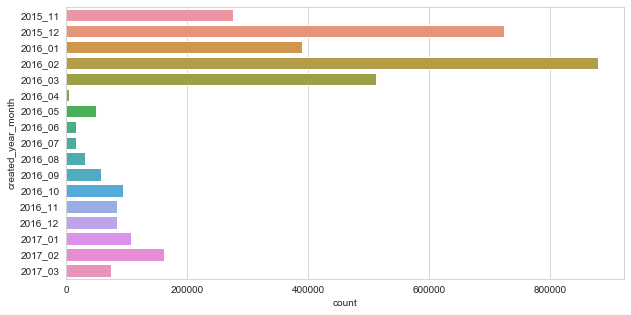

In [253]:
plt.figure(figsize=(10,5))
sns.countplot(y=df['created_year_month'])
plt.show()

As we can see above, the volumes of car ads per month vary, especially across March and Aprill 2016. This is presumably because scrapping method had been tuned up in that time. I decided to shorten the scraping timeframe window, as this should provide more coherent data and improve overall prediction accuracy.

In [254]:
df.groupby(['created_year_month'])['price_eur'].describe()

,count,mean,std,min,25%,50%,75%,max
created_year_month,,,,,,,,
2015_11,274925.0,1.233104e+04,3.697931e+05,0.04,1490.2300,5366.40,13404.00,1.000148e+08
2015_12,724271.0,2.202072e+04,7.204187e+05,0.04,3951.4800,10078.98,18010.66,3.404523e+08
2016_01,389107.0,1.813875e+04,4.169198e+05,370.10,4001.5200,10408.40,18866.69,1.000074e+08
2016_02,879196.0,6.528335e+06,4.071998e+09,370.10,5657.0825,11950.00,19990.00,2.706149e+12
2016_03,511399.0,1.644282e+04,2.899182e+05,370.10,4996.8200,11499.00,19790.00,1.001332e+08
2016_04,4297.0,1.439998e+04,3.580285e+04,370.10,2849.7400,6846.78,14208.29,5.464202e+05
2016_05,48869.0,1.126372e+04,1.914449e+04,370.10,2900.1100,7134.27,14803.81,1.715063e+06
2016_06,15497.0,7.837597e+03,9.455459e+03,370.10,2775.7200,5514.43,9992.56,2.960400e+05
2016_07,15898.0,7.467093e+03,8.804289e+03,370.10,2775.7200,5181.31,9215.40,2.331606e+05


The scraped period will get limited to January 2016 - March 2016, as further scrapings do not show variance in the predicted variable (price_eur).

In [255]:
df = df[df['created_year_month'].between('2016_01','2016_03')]
df.to_csv('.\Cars_Jan_Mar_2016.csv')

******************************


# 2. Data preparation

In [162]:
df = pd.read_csv('./Cars_Jan_Mar_2016.csv', sep=',', low_memory=False, index_col=[0])

In [163]:
df.head()

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur,year,month,created_year_month
1258599,hyundai,i10,44373.0,2011.0,1086.0,49.0,NaN,NaN,None,man,4,5,gasoline,2016-01-15 23:48:18.351263+00,2016-07-03 18:07:57.593938+00,5900.22,2016,1,2016_01
1258590,fiat,NaN,149000.0,2000.0,1900.0,NaN,NaN,NaN,None,man,4,None,diesel,2016-01-15 23:48:00.139562+00,2016-01-20 09:03:13.640667+00,1999.07,2016,1,2016_01
1258602,audi,a1,79850.0,2011.0,1390.0,90.0,NaN,NaN,None,auto,2,4,gasoline,2016-01-15 23:48:18.44457+00,2016-07-03 18:08:03.813917+00,11990.45,2016,1,2016_01
1258603,hyundai,i10,25.0,2016.0,998.0,49.0,NaN,NaN,None,auto,4,5,gasoline,2016-01-15 23:48:18.473834+00,2016-07-03 18:08:18.223965+00,9235.34,2016,1,2016_01
1258600,hyundai,i20,50785.0,2012.0,1248.0,63.0,NaN,NaN,None,man,4,5,gasoline,2016-01-15 23:48:18.38062+00,2016-07-03 18:08:02.791752+00,8450.30,2016,1,2016_01


In [164]:
raw_len = len(df)
print(raw_len)

1779702


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779702 entries, 1258599 to 2437959
Data columns (total 19 columns):
maker                  object
model                  object
mileage                float64
manufacture_year       float64
engine_displacement    float64
engine_power           float64
body_type              object
color_slug             object
stk_year               object
transmission           object
door_count             object
seat_count             object
fuel_type              object
date_created           object
date_last_seen         object
price_eur              float64
year                   int64
month                  int64
created_year_month     object
dtypes: float64(5), int64(2), object(12)
memory usage: 271.6+ MB


In [166]:
df.columns

Index(['maker', 'model', 'mileage', 'manufacture_year', 'engine_displacement',
       'engine_power', 'body_type', 'color_slug', 'stk_year', 'transmission',
       'door_count', 'seat_count', 'fuel_type', 'date_created',
       'date_last_seen', 'price_eur', 'year', 'month', 'created_year_month'],
      dtype='object')

Converting engine_power from kW to HP units.

In [167]:
df['engine_power'] = 1.3410220888*df['engine_power']

Calculating the age of a car, when the ad was scraped, instead of the manufacturing_year.
Removing unnecessary column.

In [168]:
df['age_years'] = (df['year']-df['manufacture_year'])
df.drop(columns=['manufacture_year', 'year', 'month'], inplace=True)

Checking out the % share of null values across variables

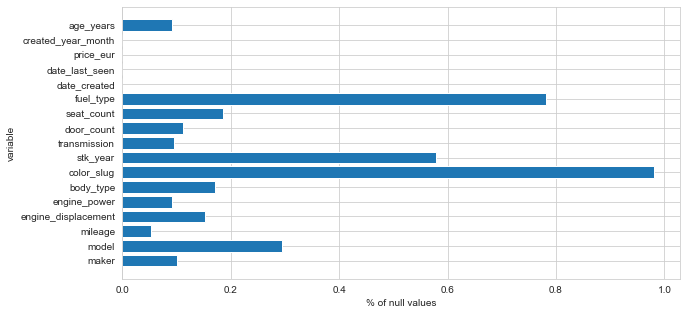

In [169]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

It seems that a number of variables have lot of missing values:

date_last_seen  - does not bring any useful information (as the policy was to remove all ads that had not been seen more than 60 days before scraping).

stk_year, color_slug  - variables that definitely need to be removed from the dataset, because of missing values

In [170]:
df.drop(columns=['stk_year', 'color_slug', 'date_last_seen'], inplace=True)

Checking out fuel type as it is not present in most cases

In [171]:
df['fuel_type'].value_counts()

gasoline    205837
diesel      183270
Name: fuel_type, dtype: int64

fuel_type should be important to predict the price but stands out in terms of missing values.
However, it can not be easily imputed, since the same engine capacities can ran with different fuel. Therefore I also decided to drop the variable. I will not be helpful in accordance to new car records.

In [172]:
df.drop(columns='fuel_type', inplace=True)

If no maker, model or manufacture_year is present in the dataset, we can not say if the price prediction is correct. These cases will also get dropped.

In [173]:
df.dropna(subset=['maker', 'model', 'age_years'], inplace=True)

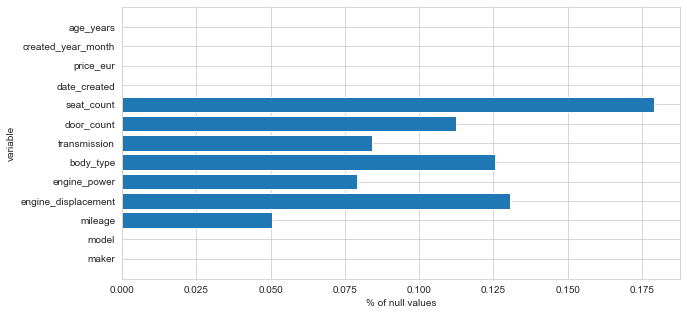

In [174]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

In [175]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years
1258599,hyundai,i10,44373.0,1086.0,65.710082,NaN,man,4,5,2016-01-15 23:48:18.351263+00,5900.22,2016_01,5.0
1258602,audi,a1,79850.0,1390.0,120.691988,NaN,auto,2,4,2016-01-15 23:48:18.44457+00,11990.45,2016_01,5.0
1258603,hyundai,i10,25.0,998.0,65.710082,NaN,auto,4,5,2016-01-15 23:48:18.473834+00,9235.34,2016_01,0.0
1258600,hyundai,i20,50785.0,1248.0,84.484392,NaN,man,4,5,2016-01-15 23:48:18.38062+00,8450.30,2016_01,4.0
1258601,hyundai,santa-fe,14487.0,2199.0,194.448203,NaN,auto,4,5,2016-01-15 23:48:18.410752+00,27901.04,2016_01,4.0


### Filtering out the outlier values

The variables present alot of variance. Some values are out of the reasonable range. See the table below.

In [176]:
df.describe()

,mileage,engine_displacement,engine_power,price_eur,age_years
count,1.081564e+06,990232.000000,1.048723e+06,1.138866e+06,1.138866e+06
mean,9.902788e+04,1814.424140,1.232749e+02,6.879184e+04,8.826922e+00
std,2.633064e+05,1342.416534,5.987303e+01,2.795810e+07,4.388576e+01
min,0.000000e+00,1.000000,2.682044e+00,3.701000e+02,0.000000e+00
25%,2.150000e+04,1389.000000,8.850746e+01,4.600000e+03,2.000000e+00
50%,7.679950e+04,1598.000000,1.086228e+02,9.980000e+03,5.000000e+00
75%,1.385000e+05,1968.000000,1.408073e+02,1.697000e+04,1.000000e+01
max,9.999999e+06,32000.000000,2.016897e+03,1.492235e+10,2.016000e+03


The dataset obiously shows outliers. I decided to trim 0.5 percentile values on each edge of a variable.
The outliers will be set as with np.nan values and imputed in fursher step.

In [177]:
for i in df.describe().columns:
    df[i] = np.where(df[i].between(df[i].quantile(q=0.005), df[i].quantile(q=0.995)), df[i], np.nan)

In [178]:
df.describe()

,mileage,engine_displacement,engine_power,price_eur,age_years
count,1.076156e+06,980509.000000,1.039204e+06,1.127484e+06,1.133362e+06
mean,8.757411e+04,1746.097122,1.216716e+02,1.239726e+04,6.744254e+00
std,7.429605e+04,607.581520,5.250845e+01,1.070496e+04,5.721709e+00
min,0.000000e+00,800.000000,4.961782e+01,5.181300e+02,0.000000e+00
25%,2.128600e+04,1390.000000,8.850746e+01,4.663210e+03,2.000000e+00
50%,7.600000e+04,1598.000000,1.086228e+02,9.980000e+03,5.000000e+00
75%,1.372500e+05,1968.000000,1.408073e+02,1.690000e+04,1.000000e+01
max,3.723460e+05,6800.000000,4.237630e+02,8.032500e+04,4.500000e+01


We will nextattempt to drop outliers for door_count and seat_count, as both variables ar strings.

In [179]:
df[['door_count', 'seat_count']] = df[['door_count', 'seat_count']].replace('None', np.nan).apply(pd.to_numeric)

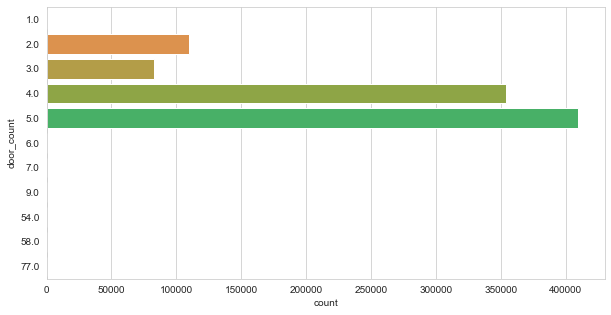

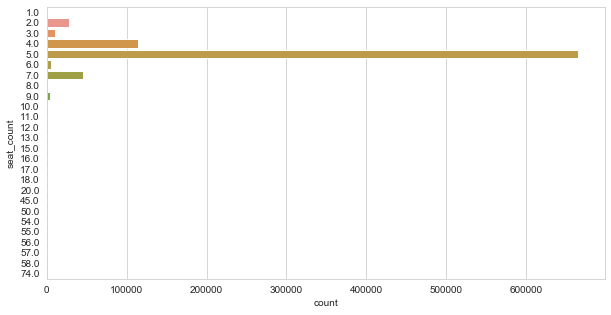

In [180]:
for i in ['door_count', 'seat_count']:
    plt.figure(figsize=(10,5))
    sns.countplot(y=df[i])
    plt.show()

Drop cars with atypical door_number, since data scraped should include regular cars only.

In [181]:
df = df[df['door_count'].between(2,5)]

### Imputing missing values with means and mode for groups

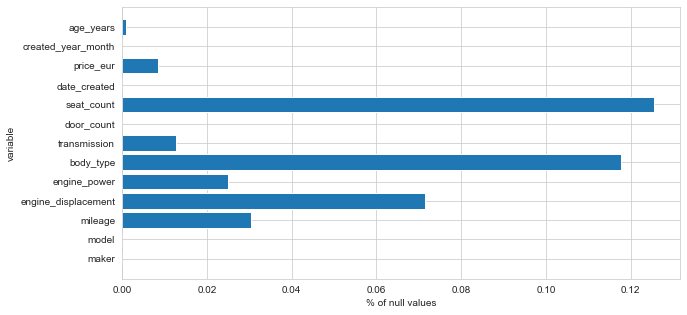

In [182]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

Input millage with mean in accordance to age of a car

In [183]:
df['mileage'] = df['mileage'].fillna(df.groupby(['age_years'])['mileage'].transform('mean'))

Impute engine_power, engine_displacement, seat_count and transmission with a mode for model and manufacture_year

In [184]:
vars = ['seat_count', 'transmission', 'engine_power', 'engine_displacement']
for i in vars:
    df[i] = df.groupby(['model'])[i].transform(lambda x: x.fillna(x.mode()))

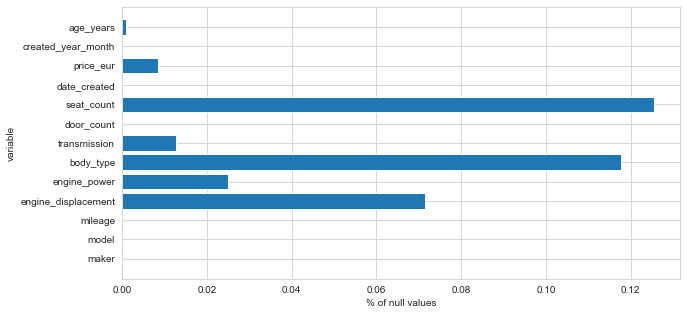

In [185]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

As we have reached serious imporovement can be reached, let's remove the records with missing values.

In [186]:
df.dropna(inplace=True)

By far the volume of the dataset is now some 40% of the initial dataset for specified period.

In [187]:
len(df), len(df)/raw_len

(709105, 0.398440300679552)

The cleaned dataset consists now of 709 105 cars, that is 39% of the initial file.

### Checking out the remaining variables

In [188]:
df['body_type'].value_counts(normalize=True)

other          0.983753
compact        0.007024
van            0.005085
convertible    0.001390
transporter    0.001382
coupe          0.001365
Name: body_type, dtype: float64

The category 'other' is prevailing over the body_type variable. The value of this variable is doubtful since 'other' includes most brands and models (SUV cars, truckts, as well as small compact cars). 

In [189]:
df[df['body_type']=='other'].head()

,maker,model,mileage,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years
1260447,audi,q3,63933.0,1968.0,174.332872,other,auto,4.0,5.0,2016-01-16 01:34:02.783133+00,27990.0,2016_01,4.0
1260324,ford,transit,202600.0,1998.0,99.235635,other,man,4.0,9.0,2016-01-16 01:33:55.01396+00,2990.0,2016_01,15.0
1256544,toyota,yaris,14.0,1364.0,88.507458,other,man,5.0,5.0,2016-01-15 22:12:36.407341+00,13900.0,2016_01,1.0
1264644,mazda,cx-7,113916.0,2261.0,256.135219,other,man,4.0,5.0,2016-01-16 06:08:28.84931+00,9300.0,2016_01,8.0
1263957,hyundai,santa-fe,156559.0,2656.0,186.402070,other,man,5.0,5.0,2016-01-16 05:36:51.790394+00,5250.0,2016_01,9.0


In [190]:
df.drop(columns='body_type', inplace=True)

*************************

### Sampling the data frame to speed up modeling

<b> Before we go further with modeling I will make a sample of the dataset. This will speed up the learning process.

In [191]:
# original data size in volume and as % of raw dataframe.
len(df), len(df)/raw_len

(709105, 0.398440300679552)

In [192]:
df = df.sample(n=50000, random_state=random_seed).reset_index(drop=True)

In [193]:
len(df)

50000

In [194]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years
0,volkswagen,golf,11500.000000,1968.0,138.125275,man,2.0,4.0,2016-02-13 12:54:14.602503+00,20990.00,2016_02,1.0
1,skoda,fabia,148575.323746,1390.0,73.756215,man,5.0,5.0,2016-02-16 21:43:51.937924+00,1961.51,2016_02,11.0
2,volkswagen,golf-sportsvan,28000.000000,1598.0,108.622789,man,5.0,5.0,2016-02-11 08:17:57.837905+00,21500.00,2016_02,1.0
3,opel,astra,66500.000000,1364.0,138.125275,man,4.0,5.0,2016-03-06 02:04:52.879522+00,10364.54,2016_03,5.0
4,opel,agila,58278.000000,1200.0,84.484392,man,5.0,5.0,2016-02-18 21:17:21.843623+00,4800.00,2016_02,8.0


In [195]:
numeric_cols = ['price_eur' , 'age_years', 'mileage', 'engine_displacement', 'engine_power'] 

The graph below shows that there is a big variance over car metrics. We can see the presence of outlier values.

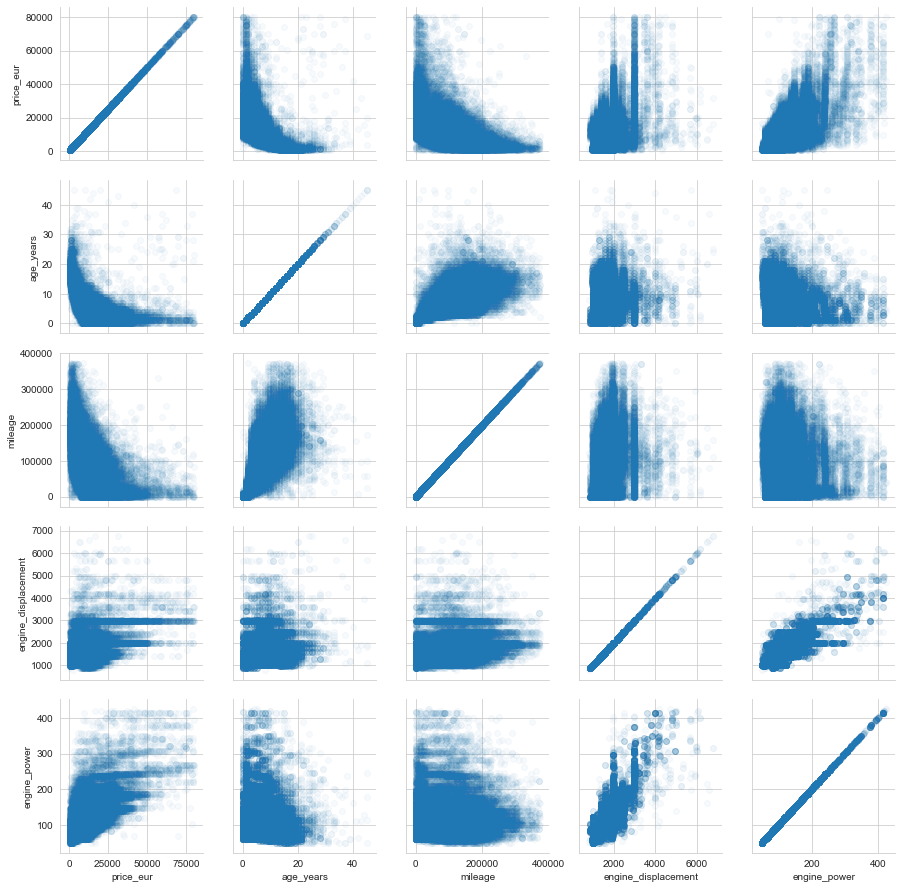

In [196]:
graph = sns.PairGrid(df[numeric_cols])
graph.map(plt.scatter, alpha=0.03)
plt.show()

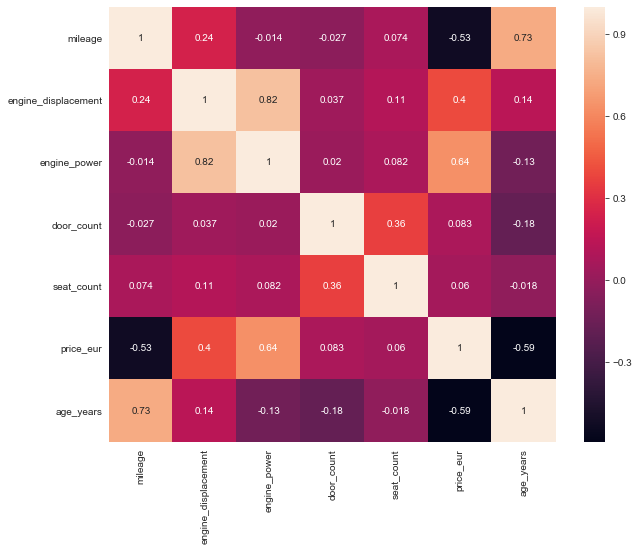

In [197]:
# Using Pearson Correlation Matrix
fig = plt.figure(figsize=(10,8))
cor = df.corr()
ax = sns.heatmap(cor, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Apart from:
- engine_power vs. engine_displacement (cor=0.82,  
- mileage vs. age_years (cor=0.73)
- price_eur vs. engine_power (cor=0.64)

there is no other significant correlation between metrics. 

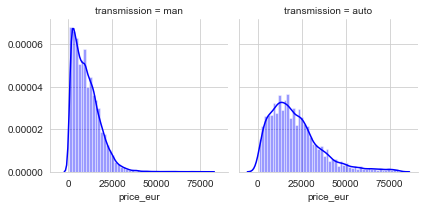

In [198]:
ax = sns.FacetGrid(data=df,col='transmission')
ax.map(sns.distplot, 'price_eur', color='blue')
plt.show()

In [ ]:
ax = sns.FacetGrid(data=df,col='door_count')
ax.map(sns.distplot, 'price_eur', color='blue')
plt.show()

In [ ]:
ax = sns.FacetGrid(data=df,col='seat_count')
ax.map(sns.distplot, 'price_eur', color='blue')
plt.show()

It also seems that price distributions vs. transmission differ, so this variable will be included in modelling.

*************************

## Attempt to cluster cars before modelling

<b> Since we dropped much of categorical data in order predict car prices I will attempt to cluster cars into some homogenic groups. If the clustering will go fine, the clusters will be considered in furher price predictions, if not I will skip this step and go on with modeling section with no additional information about clusters.

In [199]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

Please note that due to manufacturer downsizing the same engine_displacement can result in completely different engine_power in accordance to age and make of a car.

In [200]:
# an expample how engine_power varies across the same engine_displacement
df['engine_power'][df['engine_displacement'].between(1490,1495)].describe()

count     63.000000
mean      93.126534
std       13.506725
min       67.051104
25%       80.461325
50%       95.212568
75%      107.281767
max      112.645855
Name: engine_power, dtype: float64

In [201]:
data_for_clustering = df[['engine_power', 'seat_count']]
data_for_clustering.head()

,engine_power,seat_count
0,138.125275,4.0
1,73.756215,5.0
2,108.622789,5.0
3,138.125275,5.0
4,84.484392,5.0


In [202]:
#MiniBatchClustering
data_clustered = StandardScaler().fit_transform(data_for_clustering)

clusters = range(2, 15)
silhouette = []
inertia  = []
for k in clusters:
    
    model = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=random_seed)
    
    model.fit(data_clustered)
    
    silhouette.append(silhouette_score(data_clustered, model.predict(data_clustered)))
    inertia.append(model.inertia_)

Plotting Silhouette and Inertia scores to set up optimal number of clusters

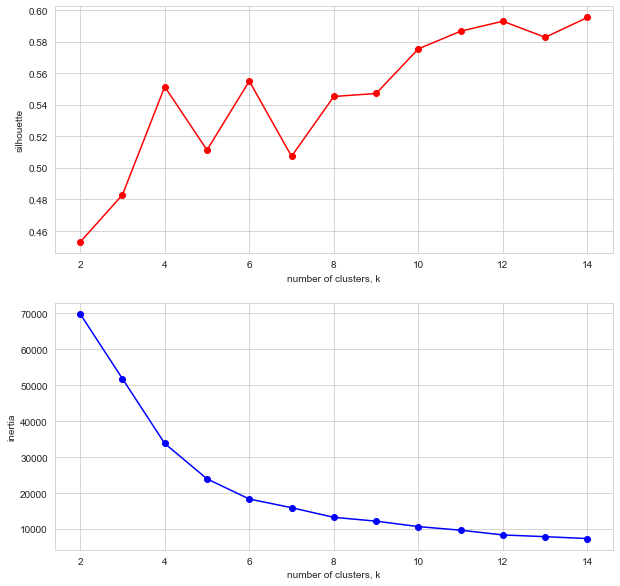

In [203]:
# Plot clusters vs silhouette
plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(clusters, silhouette, 'r-o', )
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette')

plt.subplot(2, 1, 2)
# Plot clusters vs silhouette
plt.plot(clusters, inertia, 'b-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')

plt.show()

The optimal values out of the specified cluster range is 6.

In [238]:
cluster_model = MiniBatchKMeans(n_clusters=12)
cluster_model.fit(data_clustered)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=12, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [239]:
df['cluster']=cluster_model.predict(data_clustered)

In [240]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years,cluster
0,volkswagen,golf,11500.000000,1968.0,138.125275,man,2.0,4.0,2016-02-13 12:54:14.602503+00,20990.00,2016_02,1.0,11
1,skoda,fabia,148575.323746,1390.0,73.756215,man,5.0,5.0,2016-02-16 21:43:51.937924+00,1961.51,2016_02,11.0,1
2,volkswagen,golf-sportsvan,28000.000000,1598.0,108.622789,man,5.0,5.0,2016-02-11 08:17:57.837905+00,21500.00,2016_02,1.0,10
3,opel,astra,66500.000000,1364.0,138.125275,man,4.0,5.0,2016-03-06 02:04:52.879522+00,10364.54,2016_03,5.0,6
4,opel,agila,58278.000000,1200.0,84.484392,man,5.0,5.0,2016-02-18 21:17:21.843623+00,4800.00,2016_02,8.0,1


In [241]:
df['cluster'].value_counts()

10    12294
1     10632
6      6048
0      4276
7      4185
5      3580
8      2375
3      1759
11     1758
4      1332
9      1000
2       761
Name: cluster, dtype: int64

In [242]:
groups = df.groupby(by='cluster')['price_eur', 'engine_power', 'seat_count', 'door_count', 'age_years'].mean()

Check out how the clusters are formed:

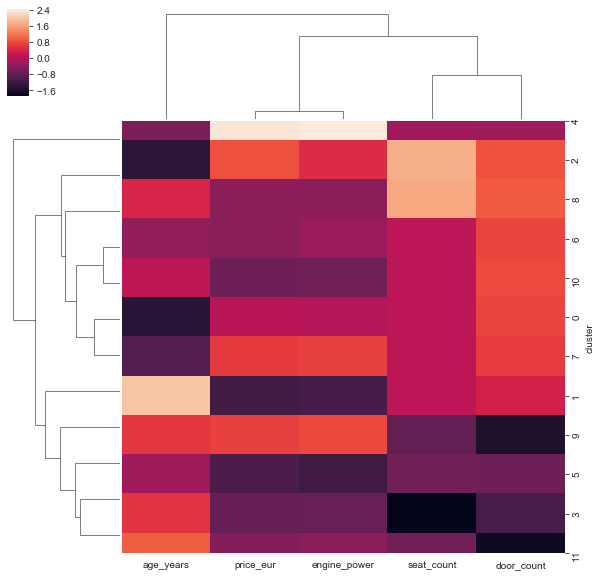

In [243]:
sns.clustermap(groups, z_score=1)
plt.show()

In [244]:
print(groups)

            price_eur  engine_power  seat_count  door_count  age_years
cluster                                                               
0        16929.772928    150.004736    5.019177    4.425398   5.047007
1         6489.666067     75.806218    5.001411    4.152652   8.185196
2        23811.002536    179.996531    7.248357    4.513798   5.084100
3         9757.094110     99.148724    2.300739    3.175099   6.903354
4        37096.656134    305.846666    4.623874    3.774775   5.850601
5         7277.890813     70.583087    4.000000    3.431564   6.199441
6        12824.747328    132.471829    5.006118    4.431878   6.098545
7        21954.762084    192.810137    5.010992    4.365352   5.466428
8        13157.683983    123.869787    7.166737    4.563368   6.754947
9        22436.666880    198.554413    3.805000    2.815000   6.928000
10       10331.387371    106.249549    5.011225    4.460062   6.473646
11       12417.560626    123.262662    3.986917    2.682594   7.255404


As we can see below one car model falls into several clusters, whis is not what we would like to accept, since prices are rather differentiated in accordance to models. Have a look ford mondeo, which falls into two clusters 5 and 0:

In [245]:
df[(df['maker']=='ford') & (df['model']=='mondeo')]

,maker,model,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years,cluster
306,ford,mondeo,203000.000000,1798.0,123.374032,man,5.0,5.0,2016-02-25 15:48:13.124313+00,2499.00,2016_02,14.0,6
325,ford,mondeo,24050.000000,1997.0,177.014916,man,4.0,5.0,2016-03-08 12:33:53.322747+00,26989.00,2016_03,1.0,7
561,ford,mondeo,178115.379140,1800.0,88.507458,man,5.0,5.0,2016-02-10 19:55:22.375614+00,740.19,2016_02,17.0,1
594,ford,mondeo,168676.522586,1998.0,113.986878,man,4.0,5.0,2016-02-10 19:56:12.526297+00,1850.11,2016_02,14.0,10
875,ford,mondeo,63935.000000,1997.0,138.125275,auto,4.0,5.0,2016-03-03 17:43:24.701833+00,14257.70,2016_03,3.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49458,ford,mondeo,72009.000000,1997.0,138.125275,man,5.0,5.0,2016-02-20 03:20:36.776072+00,15780.00,2016_02,2.0,6
49513,ford,mondeo,236912.000000,1998.0,128.738121,man,5.0,5.0,2016-02-15 21:22:06.87144+00,990.00,2016_02,14.0,6
49659,ford,mondeo,120255.699360,1600.0,108.622789,man,5.0,5.0,2016-02-27 16:00:57.716236+00,6957.81,2016_02,8.0,10
49888,ford,mondeo,180000.000000,1998.0,113.986878,man,4.0,5.0,2016-03-10 08:25:47.426674+00,1999.00,2016_03,13.0,10


Despite that I will inlude clusters in the modelling proces, since had previously dropped a few categorical variables due to data quality.

In [246]:
df.to_csv('.\Cars_sample_cleaned_50k.csv')

***************

## 3. Modeling car prices

### Defining target variable and split dataset into training and testing set

In [34]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

from sklearn import  metrics

In [35]:
df = pd.read_csv('./Cars_sample_cleaned_50k.csv', sep=',', low_memory=False, index_col=[0])

In [36]:
df.shape

(50000, 13)

In [37]:
df.columns

Index(['maker', 'model', 'mileage', 'engine_displacement', 'engine_power',
       'transmission', 'door_count', 'seat_count', 'date_created', 'price_eur',
       'created_year_month', 'age_years', 'cluster'],
      dtype='object')

In [38]:
df.dtypes

maker                   object
model                   object
mileage                float64
engine_displacement    float64
engine_power           float64
transmission            object
door_count             float64
seat_count             float64
date_created            object
price_eur              float64
created_year_month      object
age_years              float64
cluster                  int64
dtype: object

In [39]:
df['transmission'].value_counts()

man     39523
auto    10477
Name: transmission, dtype: int64

In [40]:
df['transmission'] = df['transmission'].apply(lambda x: 0 if (x=='man') else 1) 

In [41]:
cat_variables = ['door_count', 'seat_count', 'cluster']

for i in cat_variables:
    df[i] = df[i].astype('category')

In a series of experiments it turned out that cluster did not increase prediction accuracy, so I decide to drop it.

In [46]:
y = df['price_eur']
X = df.drop(['maker', 'model', 'price_eur', 'date_created', 'created_year_month', 'cluster'], axis=1)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [48]:
X.head()

,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,age_years
0,11500.000000,1968.0,138.125275,0,2.0,4.0,1.0
1,148575.323746,1390.0,73.756215,0,5.0,5.0,11.0
2,28000.000000,1598.0,108.622789,0,5.0,5.0,1.0
3,66500.000000,1364.0,138.125275,0,4.0,5.0,5.0
4,58278.000000,1200.0,84.484392,0,5.0,5.0,8.0


### Setting up kfold cross-validation criteria

In [49]:
kfold = model_selection.KFold(n_splits=5, random_state=random_seed)

### Specify pipeline

Creating the preprocessing pipeline for both numeric and categorical data, and separately for each type to use it across models.

In [50]:
numeric_features = ['mileage', 'engine_displacement','engine_power', 'age_years']
# since tranmission is coded 0/1 now, there is no need to scale it.
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['door_count', 'seat_count' ] 
#'cluster' - I decided to drop it from computations since it did not improve the score.
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

full_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

num_preprocessor_only = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)])

cat_preprocessor_only = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])


##  Linear regression

In [51]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3, 4]}

lm_1 = GridSearchCV(
    make_pipeline(#cat_preprocessor_only, # it seems that one hot cat_preprocessing on 'door_count' and 'seat_count' worsens the prediction
                  PolynomialFeatures(degree=2), 
                  linear_model.LinearRegression()),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_1.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'polynomialfeatures__degr

In [52]:
print(lm_1.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_1.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_1.predict(X_test)))

{'polynomialfeatures__degree': 2} 
R2: 0.8352794670981778 
MAE: 2609.2751945627383


## Linear regression - ridge regularization 

In [53]:
param_grid={'polynomialfeatures__degree': [1, 2, 3],
            'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

lm_2_rr = GridSearchCV(
    make_pipeline(#cat_preprocessor_only, # it seems that one hot cat_preprocessing on 'door_count' and 'seat_count' worsens the prediction
                  PolynomialFeatures(degree=2), 
                  linear_model.Ridge(random_state=random_seed)),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_2_rr.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.5397e-24): result may not be accurate.
  overwrite_a=True).T


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False, random_state=42,
                                              solver='auto', tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'polynomialfeatures__deg

In [54]:
print(lm_2_rr.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_2_rr.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_2_rr.predict(X_test)))

{'polynomialfeatures__degree': 2, 'ridge__alpha': 100} 
R2: 0.8352836652180116 
MAE: 2608.5165853202184


## Linear Regression - lasso regularization

In [55]:
param_grid={'polynomialfeatures__degree': [1, 2, 3],
            'lasso__alpha': [0.01, 0.1, 1, 10, 100]}

lm_3_lr = GridSearchCV(
    make_pipeline(
        #cat_preprocessor_only, # it seems that one hot cat_preprocessing on 'door_count' and 'seat_count' worsens the prediction 
        PolynomialFeatures(degree=2), linear_model.Lasso(random_state=random_seed)),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_3_lr.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304427021399.4315, tolerance: 434686998.0935956
  positive)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False, random_state=42,
                                              selection='cyclic', tol=0.0001,
                                              warm_start

In [56]:
print(lm_3_lr.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_3_lr.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_3_lr.predict(X_test)))

{'lasso__alpha': 0.1, 'polynomialfeatures__degree': 3} 
R2: 0.8498649474975175 
MAE: 2402.682217237514


## Linear regression - elasticnet regularization

In [57]:
param_grid={'polynomialfeatures__degree': [1, 2, 3],
            'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

lm_4_en = GridSearchCV(
    make_pipeline(
        #cat_preprocessor_only, # it seems that one hot cat_preprocessing on 'door_count' and 'seat_count' worsens the prediction 
        PolynomialFeatures(degree=2), linear_model.ElasticNet(alpha=1, random_state=random_seed)),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_4_en.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304815256130.8893, tolerance: 434686998.0935956
  positive)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('elasticnet',
                                        ElasticNet(alpha=1, copy_X=True,
                                                   fit_intercept=True,
                                                   l1_ratio=0.5, max_iter=1000,
                                                   normalize=False,
                                                   positive=False,
                                                   precompute=False,
            

In [58]:
print(lm_4_en.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_4_en.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_4_en.predict(X_test)))

{'elasticnet__alpha': 0.1, 'polynomialfeatures__degree': 3} 
R2: 0.8492410042042565 
MAE: 2402.884777627825


## Support Vector Regression

In [74]:
# This part was skipped due to the fact that algorithm did not manage to train the model within 12 hours.

In [59]:
# pipe = Pipeline([('preprocessing', make_pipeline(full_preprocessor)), ('SVR', SVR(kernel='rbf'))])

# param_grid = {'preprocessing': [make_pipeline(full_preprocessor), make_pipeline(cat_preprocessor_only), None],
#               'SVR__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
#               'SVR__C': [1, 10, 100, 1000, 10000, 20000]}

# svr_5 = GridSearchCV(pipe, 
#                      param_grid, 
#                      cv=kfold, 
#                      return_train_score=True, 
#                      n_jobs=-1)

# svr_5.fit(X_train, y_train)

In [60]:
# print(svr_5.best_params_, 
#       '\nR2:', metrics.r2_score(y_test, svr_5.predict(X_test)), 
#       '\nMAE:', metrics.mean_absolute_error(y_test, svr_5.predict(X_test)))

## Random forest regression

In [61]:
param_grid = {'n_estimators': [20, 50, 100, 200, 500],
              'max_depth':  [20, 50, 100, 200],  
              'max_features': ['log2','sqrt','auto'],
              'max_leaf_nodes':  [100, 200, 300, 500]}

rfr = RandomForestRegressor(n_jobs=-1, max_features='sqrt', n_estimators=50, 
                            oob_score = True, random_state=random_seed)
                 
rfr_6 = GridSearchCV(rfr,
                     param_grid=param_grid,
                     cv=kfold, 
                     n_jobs=-1)

rfr_6.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=50, n_jobs=-1,
                                             oob_score=True, random_state=42,
                                             verbose=0,

In [62]:
print(rfr_6.best_params_, 
      '\nR2:', metrics.r2_score(y_test, rfr_6.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, rfr_6.predict(X_test)))

{'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': 500, 'n_estimators': 200} 
R2: 0.8953666216325928 
MAE: 2140.8990591205916


Printing out feature importances for RFR model:

In [63]:
feat_importances = pd.Series(data=rfr_6.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=True)

In [64]:
feat_importances.index

Index(['door_count', 'seat_count', 'transmission', 'engine_displacement',
       'mileage', 'engine_power', 'age_years'],
      dtype='object')

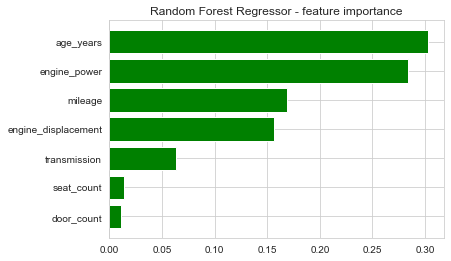

In [65]:
plt.barh(feat_importances.index, feat_importances.values, color='green')
plt.title('Random Forest Regressor - feature importance')
plt.show()

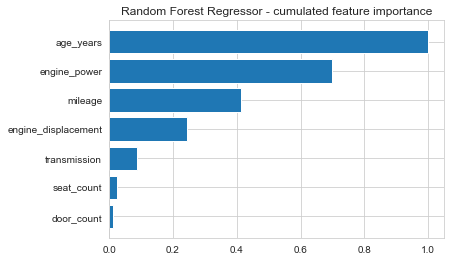

In [66]:
plt.barh(feat_importances.index, feat_importances.values.cumsum())
plt.title('Random Forest Regressor - cumulated feature importance')
plt.show()

As it was shown in the correlation matrix the most important features to predict car prices is age power, engine_displacement and mileage. The remaining predictors are of minor imporance.

## Gradient Boosting Regressor

In [67]:
pipe = Pipeline([('preprocessing', make_pipeline(full_preprocessor)), 
                 ('GBR', GradientBoostingRegressor(loss='ls', n_estimators=50, random_state=random_seed))])

param_grid = {'preprocessing': [make_pipeline(full_preprocessor), make_pipeline(cat_preprocessor_only), None],
              'GBR__n_estimators': [50, 100, 200, 500, 700]
             }

gbr_7 = GridSearchCV(pipe,
                     param_grid=param_grid,
                     cv=kfold, 
                     n_jobs=-1)

gbr_7.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        Pipeline(memory=None,
                                                 steps=[('columntransformer',
                                                         ColumnTransformer(n_jobs=None,
                                                                           remainder='drop',
                                                                           sparse_threshold=0.3,
                                                                           transformer_weights=None,
                                                                           transformers=[('num',
                                                                                          Pipeline(memory=None,
                                                                         

In [68]:
print(gbr_7.best_params_, 
      '\nR2:', metrics.r2_score(y_test, gbr_7.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, gbr_7.predict(X_test)))

{'GBR__n_estimators': 700, 'preprocessing': None} 
R2: 0.9019345688510817 
MAE: 2008.5805414517217


## Neural Network KerasRegressor

In [84]:
scaler = StandardScaler()

NNregressor = Sequential()
NNregressor.add(Dense(7, input_shape=(7,), kernel_initializer='normal', activation='relu'))
NNregressor.add(Dense(35, kernel_initializer='normal', activation='relu'))
NNregressor.add(Dense(14, kernel_initializer='normal', activation='relu'))
NNregressor.add(Dense(1, kernel_initializer='normal'))
NNregressor.compile(loss="mse", optimizer="adam", metrics=['mae'])
NNregressor.summary()

early_stopping = EarlyStopping(monitor='loss', patience=8)

NNregressor.fit(scaler.fit_transform(X_train), y_train,
              epochs=200,
              validation_split=0.2,
              callbacks=[early_stopping])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_22 (Dense)             (None, 35)                280       
_________________________________________________________________
dense_23 (Dense)             (None, 14)                504       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 15        
Total params: 855
Trainable params: 855
Non-trainable params: 0
_________________________________________________________________
Train on 32000 samples, validate on 8000 samples
Epoch 1/200
32000/32000 [==============================] - 3s 85us/step - loss: 154099554.4595 - mae: 8615.2988 - val_loss: 27426447.2000 - val_mae: 3538.7571
Epoch 2/200
32000/32000 [=====================

Epoch 47/200
32000/32000 [==============================] - 2s 73us/step - loss: 19315386.3155 - mae: 2626.0547 - val_loss: 17725437.5820 - val_mae: 2584.1082
Epoch 48/200
32000/32000 [==============================] - 2s 73us/step - loss: 19309809.2118 - mae: 2625.3186 - val_loss: 17576467.2920 - val_mae: 2590.2852
Epoch 49/200
32000/32000 [==============================] - 2s 74us/step - loss: 19287391.7752 - mae: 2623.0803 - val_loss: 17573027.8580 - val_mae: 2585.0242
Epoch 50/200
32000/32000 [==============================] - 2s 73us/step - loss: 19254182.2713 - mae: 2624.1438 - val_loss: 17545356.4340 - val_mae: 2582.4294
Epoch 51/200
32000/32000 [==============================] - 2s 73us/step - loss: 19249413.3795 - mae: 2622.1326 - val_loss: 17716252.9790 - val_mae: 2582.5549
Epoch 52/200
32000/32000 [==============================] - 2s 73us/step - loss: 19254696.7175 - mae: 2623.2986 - val_loss: 17549176.2480 - val_mae: 2578.3394
Epoch 53/200
32000/32000 [====================

32000/32000 [==============================] - 2s 78us/step - loss: 19003862.8880 - mae: 2615.1318 - val_loss: 17258724.3750 - val_mae: 2581.3235
Epoch 99/200
32000/32000 [==============================] - 3s 78us/step - loss: 18991332.4842 - mae: 2617.9705 - val_loss: 17388808.8740 - val_mae: 2570.0171
Epoch 100/200
32000/32000 [==============================] - 2s 77us/step - loss: 18986163.0410 - mae: 2615.0388 - val_loss: 17647874.7870 - val_mae: 2580.7166
Epoch 101/200
32000/32000 [==============================] - 2s 77us/step - loss: 19000230.4565 - mae: 2620.9248 - val_loss: 17247699.6500 - val_mae: 2570.4895
Epoch 102/200
32000/32000 [==============================] - 2s 77us/step - loss: 18982579.2457 - mae: 2616.9241 - val_loss: 17235305.5410 - val_mae: 2573.7354
Epoch 103/200
32000/32000 [==============================] - 2s 76us/step - loss: 19012954.5902 - mae: 2617.6211 - val_loss: 17203319.2010 - val_mae: 2574.1292
Epoch 104/200
32000/32000 [============================

In [85]:
print('\nR2:', metrics.r2_score(y_test,NNregressor.predict(scaler.transform(X_test))), 
      '\nMAE:', metrics.mean_absolute_error(y_test,NNregressor.predict(scaler.transform(X_test))))


R2: 0.8304641999677191 
MAE: 2581.1277481998754


## 5. Model Comparison Summary

In [75]:
models = []
models.append(('Linear', lm_1.best_estimator_))
models.append(('Ridge', lm_2_rr.best_estimator_))
models.append(('Lasso', lm_3_lr.best_estimator_))
models.append(('ElasticNet', lm_4_en.best_estimator_))
#models.append(('Support Vector Regressor', svr_5.best_estimator_))
models.append(('Random Forrest', rfr_6.best_estimator_))
models.append(('Gradient Boosting', gbr_7.best_estimator_))
models.append(('Keras NN Regressor', NNregressor))

r2 = []
mean_absolute_error = []
for name, model in models:
    if name!='Keras NN Regressor':
        print(name)
        print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
        print("Mean absolute error: {}".format( metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
        r2.append(metrics.r2_score(y_test, model.predict(X_test)))
        mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))
    else: 
        print(name)
        print("R^2: {}".format(metrics.r2_score(y_test,NNregressor.predict(scaler.transform(X_test))) )) 
        print("Mean absolute error: {}".format(metrics.mean_absolute_error(y_test,NNregressor.predict(scaler.transform(X_test))) ))
        r2.append(metrics.r2_score(y_test,NNregressor.predict(scaler.transform(X_test))))
        mean_absolute_error.append(metrics.mean_absolute_error(y_test,NNregressor.predict(scaler.transform(X_test))))
    print("------------------------------------------")
    

Linear
R^2: 0.8352794670981778
Mean absolute error: 2609.2751945627383
------------------------------------------
Ridge
R^2: 0.8352836652180116
Mean absolute error: 2608.5165853202184
------------------------------------------
Lasso
R^2: 0.8498649474975175
Mean absolute error: 2402.682217237514
------------------------------------------
ElasticNet
R^2: 0.8492410042042565
Mean absolute error: 2402.884777627825
------------------------------------------
Random Forrest
R^2: 0.8953666216325928
Mean absolute error: 2140.8990591205916
------------------------------------------
Gradient Boosting
R^2: 0.9019345688510817
Mean absolute error: 2008.5805414517217
------------------------------------------
Keras NN Regressor
R^2: 0.830477088389555
Mean absolute error: 2581.820153999432
------------------------------------------


In [77]:
d = {'R2': r2, 
     'MAE': mean_absolute_error}
df_models = pd.DataFrame(data=d)
df_models.insert(loc=0, column='Method', value=['Linear Regression',
                                                'Ridge',
                                                'Lasso', 
                                                'ElasticNet',
                                                #'Support Vector Regressor',
                                                'Random Forrest Regressor',
                                                'Gradient Boosting Regressor',
                                                'Keras NN Regressor'])
df_models.set_index('Method', inplace=True)

df_models.to_csv('./model_results.csv')

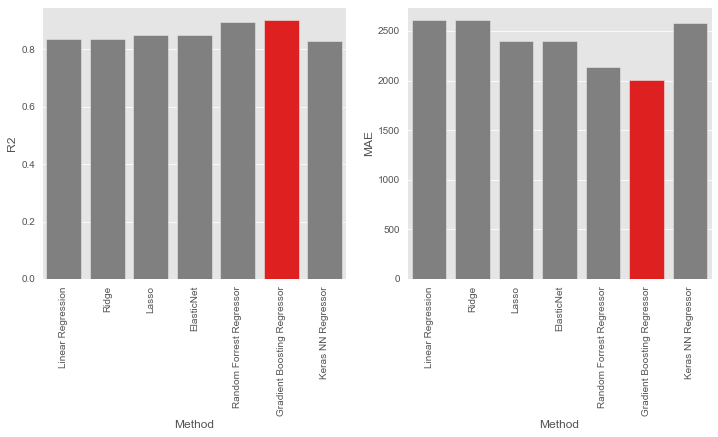

In [78]:
plt.style.use('ggplot')
plt.figure(figsize=(12,5))
plt.subplot(121)

values = df_models['R2']  
idx = df_models.index

clrs = ['grey' if (x < max(values)) else 'red' for x in values ]
sns.barplot(x=idx, y=values, palette=clrs)
plt.ylabel('R2')
plt.xlabel('Method')
plt.xticks(rotation=90)


plt.subplot(122)

values2 = df_models['MAE']  
idx2 = df_models.index

clrs = ['grey' if (x > min(values2)) else 'red' for x in values2 ]
sns.barplot(x=idx, y=values2, palette=clrs)
plt.xticks(rotation=90)
plt.ylabel('MAE')
plt.xlabel('Method')

plt.show()

# Project summary

<b> On the 50 000 car dataset that was sampled from cleaned dataset I managed to reach: <font color=blue> 90% R2 score and 2008 of MAE </font>.
This means that our predicions vary from real prices about EUR 2008 on average, which is some 16%.</b>


Gradient Boosting Regressor proved to be best algorithm out of the methods checked. The second one was Random Forest Regresor. Neural Network did not work that well on the dataset, but this algorithm was run just to check as it was not tuned with grid search. Since SVR was very slow, I decided to drop it from the algorithm competition (12 hours was still not enough to train the model on the sample dataset). 

It is still not perfect, but it is more than I expected. After cleaning the dataset, just before starting to create first models, I was very anxious how my modelling will perform. Real data is far more challenging than ordinary, ready-to-used datasets that I got used to during my bootcamp clasesss. In the modelling process different approaches were checked, and some variables ned to be removed form the process. 
        
Moreover the project proved that if a categorical variable is inbalanced (such as it was a case in 'cluster', 'seat_number', or 'door_number') and as it is not directly correlated with target variable, it increases the model clomplexity, not bringing better prediction accuracy in return. As in ML no holds are barred, sometimes no variable preprocessing can bring out better results (as I decided to remove One Hot Encoding for the cariables 'seat_number' or 'door_number').
   
There is still a place to improve by tunning up models, especially neural networks. This will be performed later on as a supplement to this project (as I need to get my Laptop rest after a series of busy days).

In [161]:
# mae as % of mean price_eur 
metrics.mean_absolute_error(y_test, gbr_7.predict(X_test))/y_test.mean()

0.16079606701246354

### Comparing predicted prices to real car ad prices

In [163]:
price_predictions = pd.DataFrame(gbr_7.predict(X).round(), columns=['predicted_price_eur'])

In [164]:
df = df[['price_eur', 'maker', 'model', 'age_years',
         'mileage', 'engine_displacement', 'engine_power', 'transmission', 'cluster']]

In [165]:
frames = [price_predictions, df]
df_with_predictions = pd.concat(frames, axis=1)
df_with_predictions.head(20)

,predicted_price_eur,price_eur,maker,model,age_years,mileage,engine_displacement,engine_power,transmission,cluster
0,24991.0,20990.00,volkswagen,golf,1.0,11500.000000,1968.0,138.125275,0,11
1,3685.0,1961.51,skoda,fabia,11.0,148575.323746,1390.0,73.756215,0,1
2,18748.0,21500.00,volkswagen,golf-sportsvan,1.0,28000.000000,1598.0,108.622789,0,10
3,11823.0,10364.54,opel,astra,5.0,66500.000000,1364.0,138.125275,0,6
4,5565.0,4800.00,opel,agila,8.0,58278.000000,1200.0,84.484392,0,1
5,13833.0,17950.00,bmw,z4,9.0,87061.000000,2494.0,189.084115,0,3
6,9824.0,8777.02,citroen,c3,1.0,10.000000,999.0,67.051104,0,1
7,18885.0,20990.00,mini,cooper-s,4.0,59807.000000,1995.0,143.489364,0,0
8,25425.0,25848.00,volkswagen,transporter,1.0,10.000000,1968.0,138.125275,0,3
9,5246.0,4990.00,volkswagen,new-beetle,17.0,64987.000000,1896.0,88.507458,0,5


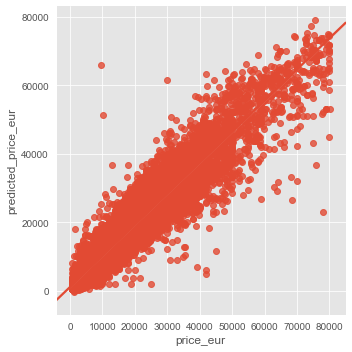

In [166]:
sns.lmplot(x='price_eur', y='predicted_price_eur', data=df_with_predictions)
plt.show()